In [20]:
import numpy as np
import pandas as pd
import sys
import sklearn.preprocessing
import sklearn.model_selection
import sklearn.metrics
import sklearn
import lazypredict
import matplotlib.pyplot as plt
from tqdm.notebook import tnrange
import itertools
from sklearn.impute import KNNImputer
import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_validate
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import FunctionTransformer
from fitter import Fitter, get_common_distributions, get_distributions
import time
from datetime import datetime

In [3]:
df_train = pd.read_csv('../DATA/train_airbnb_berlin.xls')

# without label
#df_validation = pd.read_csv('./test_airbnb_berlin.xls') 

# Pre processing

### Feature analysis

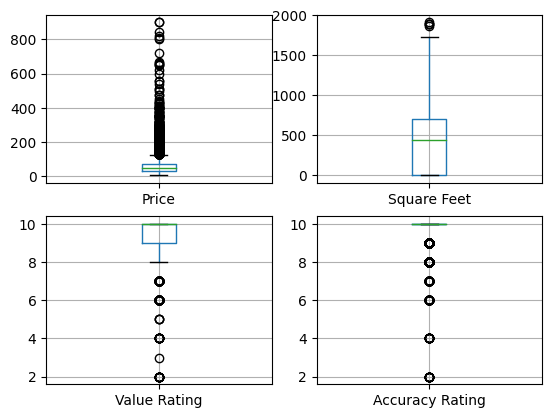

In [4]:
plt.subplot(221)
df_train.boxplot(column='Price')

plt.subplot(222)
df_train.boxplot(column='Square Feet')

plt.subplot(223)
df_train.boxplot(column='Value Rating')

plt.subplot(224)
df_train.boxplot(column='Accuracy Rating')

plt.show()

In [5]:
def percentage_of_nans(df: pd.DataFrame) -> list:
    nan_percentage = pd.DataFrame(columns=['Feature Name', 'Percentage of NaNs'])
    for idx, feature in enumerate(df.columns):
        notnans = df_train[feature].notna().value_counts()
        percentage = 0
        if False in notnans:
            percentage = int(10000*notnans[False]/len(df_train))/100

        nan_percentage.loc[idx] = [feature, percentage]
    return nan_percentage

In [6]:
nan_percentage = percentage_of_nans(df_train)
df = nan_percentage[nan_percentage['Percentage of NaNs'] >= 18]
df.sort_values(by=['Percentage of NaNs'], ascending=False).reset_index().drop(['index'], axis=1)

,Feature Name,Percentage of NaNs
0,Square Feet,98.06
1,Host Response Time,45.08
2,Host Response Rate,45.08
3,Checkin Rating,18.94
4,Accuracy Rating,18.93
5,Location Rating,18.93
6,Value Rating,18.93
7,Cleanliness Rating,18.92
8,Communication Rating,18.92
9,Overall Rating,18.87


In [57]:
df_train['Neighborhood Group'].value_counts()

Friedrichshain-Kreuzberg    3768
Mitte                       3174
Pankow                      2473
NeukÃ¶lln                   2470
Tempelhof - SchÃ¶neberg     1081
Charlottenburg-Wilm.        1065
Lichtenberg                  520
Treptow - KÃ¶penick          435
Steglitz - Zehlendorf        302
Reinickendorf                218
Marzahn - Hellersdorf        127
Spandau                       59
Name: Neighborhood Group, dtype: int64

### Data cleaning

In [71]:

def replace_na(df : pd.DataFrame, numerical_variables : list):
    
    
    imputer = KNNImputer(n_neighbors=3)
    imputer.fit(df[numerical_variables])
    imputed_values = imputer.transform(df[numerical_variables])
    df[numerical_variables] = pd.DataFrame(imputed_values, columns=numerical_variables)

    # for column in numerical_variables:
    #     df[column] = pd.to_numeric(df[column],'coerce')
    #     mean = df[column].mean()
    #     df[column] = df[column].fillna(mean)


    return df

    
def pre_process_raw(df : pd.DataFrame):

    numerical_variables = ['Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights',\
        'Reviews', 'Host Response Rate', 'Host Response Time', 'Square Feet', 'Price']
    ratings = ['Accuracy Rating', 'Value Rating', 'Checkin Rating', 'Overall Rating', 'Location Rating', 'Communication Rating', 'Cleanliness Rating']
    numerical_variables += ratings

    dates = ['Host Since', 'First Review', 'Last Review']

    categorical_variables = ['Room Type', 'Property Type', 'Neighborhood Group']

    boolean_variables = ['Is Exact Location', 'Instant Bookable', 'Business Travel Ready']

    selected_columns = numerical_variables + categorical_variables + boolean_variables + dates
        
    df = df[selected_columns].copy()
    
    df.replace(['f', 't'], [0, 1], inplace=True)
    df.replace(["*", "nan"], [np.NaN, np.NaN], inplace=True)

    # TRANSFORM HOST RESPONSE RATE 
    df['Host Response Rate'] = df['Host Response Rate'].map(lambda x: str(x), na_action='ignore').map(lambda x : int(x[:-1]), na_action='ignore')
    
    # MAP RESPONSE TIME
    mapping = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3
    }
    df['Host Response Time'] = df['Host Response Time'].map(mapping)


    # deal with dates
    for date in dates:
        df[date] = df[date].map(lambda x: datetime.fromisoformat(x).timestamp(), na_action='ignore')

        
    # categorcial to dummies
    for cat_var in categorical_variables:
        dummie = pd.get_dummies(df[cat_var])
        df = pd.concat([df, dummie], axis=1)


    # # ZIP CODE
    # zip_compressed = compress_postal_code(df)
    # zip_dummies = pd.get_dummies(zip_compressed)
    # print(zip_dummies)
    # df = pd.concat([df, zip_dummies], axis=1)
    
    # if(label_in):
    #     y = df['Price']

    df.dropna(subset=['Price'], inplace=True)
        
    df.drop(["Room Type", "Property Type", 'Neighborhood Group'], axis=1, inplace=True)
    
    # if(label_in):
    #     return df, y
    X = pd.DataFrame(df, columns=df.columns)
    y = X["Price"]
    X.drop(["Price"], axis=1, inplace=True)
    
    return X, y

In [72]:
X, y = pre_process_raw(df_train)

### Train test split

In [73]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

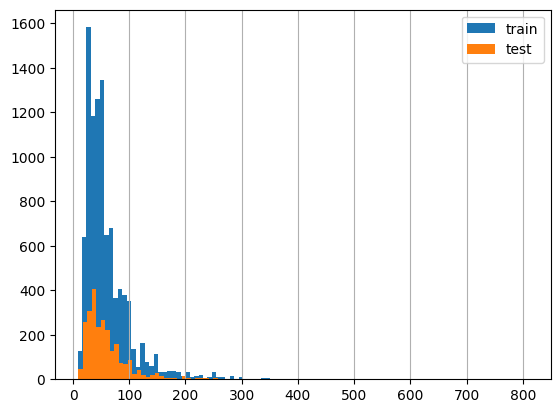

In [18]:
plt.hist(y_train,bins=100, label='train')
plt.hist(y_test, bins=100,label='test')
plt.legend()
plt.grid(axis='x')
plt.show()


Fitting 5 distributions: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,0.000074,2029.451060,-235888.491894,inf,0.042605,4.453152e-20
norm,0.000474,9060.312233,-212698.997525,inf,0.177225,0.000000e+00
beta,0.000712,2240.677384,-207626.119905,inf,0.243008,0.000000e+00
gamma,0.001490,25877.965387,-198436.462098,inf,0.993111,0.000000e+00
lognorm,0.001610,1793.410136,-197471.418287,inf,0.671810,0.000000e+00


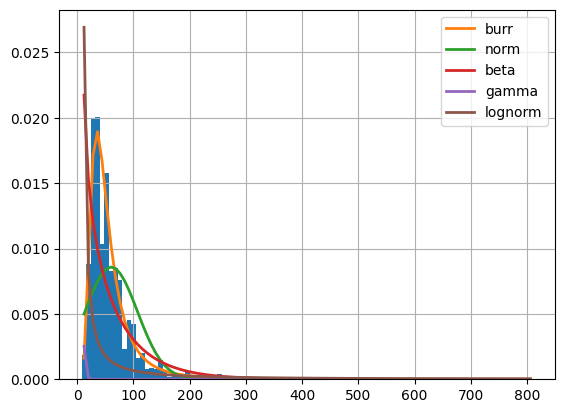

In [13]:
f = Fitter(y.values,
           distributions=['gamma',
                          'lognorm',
                          "beta",
                          "burr",
                          "norm"])
f.fit()
f.summary()

In [21]:
f_train = Fitter(y_train.values, distributions=['burr'])
f_train.fit()

display(f_train.get_best())

f_test = Fitter(y_test.values, distributions=['burr'])
f_test.fit()
display(f_test.get_best())


Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  1.33it/s]


{'burr': {'c': 2.4414347619071934,
  'd': 2.393518216021173,
  'loc': -0.09905657835144728,
  'scale': 30.347720183395648}}

Fitting 1 distributions: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]


{'burr': {'c': 2.4393543385741197,
  'd': 2.5534189715103137,
  'loc': -0.08837743142723613,
  'scale': 29.590544223713373}}

In [74]:
from scipy.special import rel_entr
from scipy.stats import burr

r_train = burr.rvs(**(f_train.get_best()['burr']),size=1000)
r_test = burr.rvs(**(f_test.get_best()['burr']),size=1000)
r_test_base = burr.rvs(**(f_test.get_best()['burr']),size=1000)
print('KL divergence between train and test: ', sum(rel_entr(r_train, r_test)))
print('KL divergence reference: ', sum(rel_entr(r_test, r_test_base)))

KL divergence between train and test:  23208.840505360564
KL divergence reference:  27383.222059747535


# Feature analysis

### PCA

In [66]:
pca = PCA()
pca.fit(X_train)
explained_variance = pca.explained_variance_ratio_
acc_sum = np.cumsum(explained_variance) 

plt.title('Cumulative explained variance')
plt.plot(acc_sum)
plt.grid()
plt.ylabel('Explained variance')
plt.xlabel('Number of features')
plt.show()

print('Explained variance with 5 features: ', acc_sum[4])

ValueError: could not convert string to float: 'NeukÃ¶lln'

### Forward selection + Cross Validation

In [ ]:
def fit_clf(clf, X, y, params):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        model_k = clf(**params)
        model_k.fit(X_train,y_train)
        metric.append(model_k.score(X_test,y_test))
    return np.array(metric).mean()

In [ ]:
def get_feature_importance(clf, params):
	r2 = [] 
	features = []
	n_features = []

	for k in range(1,len(X.columns) + 1):
		r2_tmp = []
		for new_feat in X_train.columns:
			if new_feat in features: continue
			new_features = features.copy()
			new_features.append(new_feat)
			r2_val = fit_clf(clf, X_train[new_features],y_train, params)   
			r2_tmp.append((r2_val, new_feat))                 
		r2.append(sorted(r2_tmp, key=lambda x: x[0])[-1][0])	
		new_feat = sorted(r2_tmp, key=lambda x: x[0])[-1][1]
		features.append(new_feat)
		n_features.append(len(features))   

	df = pd.DataFrame({'n_features': n_features,'R2': r2,'features':features})

	return df

In [ ]:
df = get_feature_importance(linear_model.LinearRegression, {})
plt.title('Cross-validated subset selection - Linear Regression')
plt.xlabel('Number of features')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['n_features'], df['R2'])
plt.show()


### Autoencoder

In [114]:

n_input = X_train.columns

n_encoder1 = 50
n_encoder2 = 30

n_latent = 2

n_decoder2 = 30
n_decoder1 = 50

In [115]:
reg = MLPRegressor(hidden_layer_sizes = (n_encoder1, n_encoder2, n_latent, n_decoder2, n_decoder1), 
                   activation = 'tanh', 
                   solver = 'adam', 
                   learning_rate_init = 1e-4, 
                   max_iter = 100, 
                   tol = 0.0000001, 
                   verbose = False)

In [116]:
reg.fit(X_train, y_train)

/home/josemelocosta/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPRegressor(activation='tanh', hidden_layer_sizes=(50, 30, 2, 30, 50),
             learning_rate_init=0.0001, max_iter=100, tol=1e-07)

In [117]:
def encoder(data):
    data = np.asmatrix(data)
    
    encoder1 = data*reg.coefs_[0] + reg.intercepts_[0]
    encoder1 = (np.exp(encoder1) - np.exp(-encoder1))/(np.exp(encoder1) + np.exp(-encoder1))
    
    encoder2 = encoder1*reg.coefs_[1] + reg.intercepts_[1]
    encoder2 = (np.exp(encoder2) - np.exp(-encoder2))/(np.exp(encoder2) + np.exp(-encoder2))
    
    latent = encoder2*reg.coefs_[2] + reg.intercepts_[2]
    latent = (np.exp(latent) - np.exp(-latent))/(np.exp(latent) + np.exp(-latent))
    
    return np.asarray(latent)

test_latent = encoder(X_train)


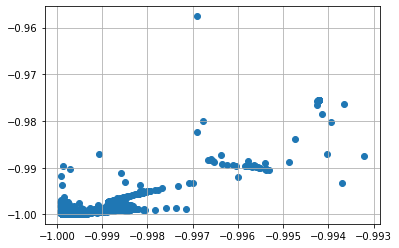

In [120]:
plt.scatter(test_latent[:, 0], test_latent[:, 1])
plt.grid()
plt.show()

# Model selection

In [76]:
def process_model_1(df:pd.DataFrame):
    df.drop(['Square Feet'], axis=1, inplace=True)
    return df


def fit_clf_scaler_cv(clf, X, y, clf_params, imputer_params, n_features=54):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]


        pipe = Pipeline([('pre_process', FunctionTransformer(process_model_1)),
        ('imputer', KNNImputer(**imputer_params)),
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=n_features)),
        ('svr', clf(**clf_params))])
        
        pipe.fit(X_train,y_train)
        metric.append(pipe.score(X_test,y_test))
    return np.array(metric).mean()

def fit_clf_scaler(clf, X, y, clf_params, imputer_params, n_features=43):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    
    pipe = Pipeline([('pre_process', FunctionTransformer(process_model_1)),
    ('imputer', KNNImputer(**imputer_params)),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_features)),
    ('svr', clf(**clf_params))])
    
    pipe.fit(X_train,y_train)
    metric = pipe.score(X_test,y_test)
    return metric 

### Decision Trees

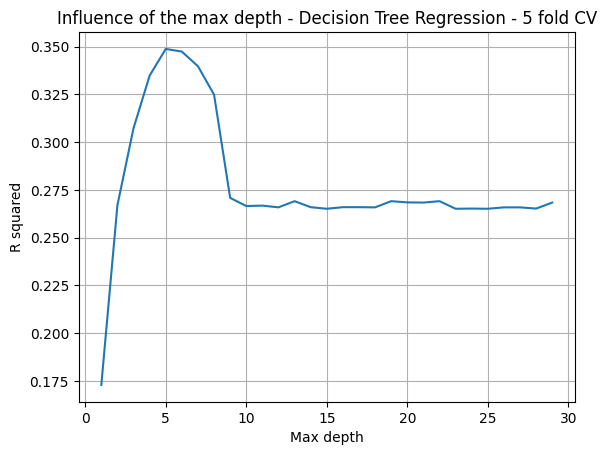

In [98]:
r2 = []
max_depth = []
for k in range(1, 30):
    r2_val = fit_clf(DecisionTreeRegressor, X_train[new_features],y_train, {"max_depth": k}) 
    r2.append(r2_val)	
    max_depth.append(k)

df = pd.DataFrame({'R2': r2,'max_depth':max_depth})
plt.title('Influence of the max depth - Decision Tree Regression - 5 fold CV')
plt.xlabel('Max depth')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['max_depth'], df['R2'])
plt.show()

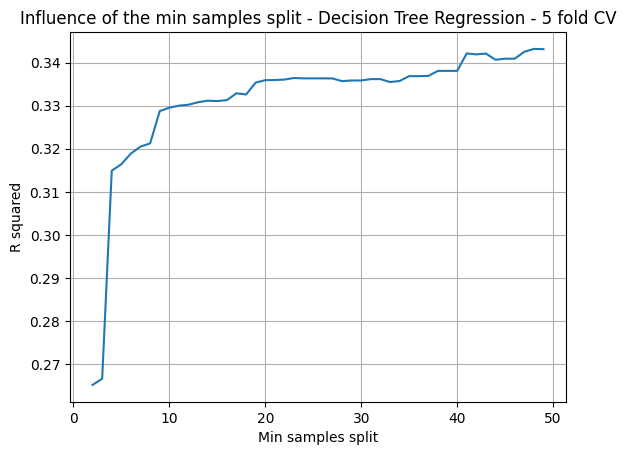

In [95]:
r2 = []
min_samples_split = []
for k in range(2, 50):
    r2_val = fit_clf(DecisionTreeRegressor, X_train[new_features],y_train, {"min_samples_split": k}) 
    r2.append(r2_val)	
    min_samples_split.append(k)

df = pd.DataFrame({'R2': r2,'min_samples_split':min_samples_split})
plt.title('Influence of the min samples split - Decision Tree Regression - 5 fold CV')
plt.xlabel('Min samples split')
plt.ylabel('R squared')
plt.grid()
plt.plot(df['min_samples_split'], df['R2'])
plt.show()

In [97]:
parameters = {'max_depth':np.arange(1, 15), 'min_samples_split':np.arange(2, 5)}
clf = GridSearchCV(DecisionTreeRegressor(), parameters)
clf.fit(X_train, y_train)
print('Best params: ', clf.best_params_)
print('Best score: ', clf.best_score_)

Best params:  {'max_depth': 4, 'min_samples_split': 2}
Best score:  0.3336581268285735


### SVM

In [16]:

def objective(trial: optuna.trial.Trial):

    parameters = {
        'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
        'C': trial.suggest_float('C', 1e-3, 1e3),
        'epsilon': trial.suggest_float('epsilon', 1e-3, 1)
    }

    clf = svm.SVR
    return -fit_clf_scaler(clf, X_train, y_train, parameters)

study = optuna.create_study()
study.optimize(objective, n_trials=1)


[I 2022-10-25 18:54:41,803] A new study created in memory with name: no-name-68da5127-3b3d-4499-8fc2-64539eb4b436
[I 2022-10-25 18:56:25,503] Trial 0 finished with value: -0.33741671800551337 and parameters: {'kernel': 'rbf', 'C': 595.6756199722245, 'epsilon': 0.8771538699650302}. Best is trial 0 with value: -0.33741671800551337.


In [77]:
clf_params = {'kernel': 'rbf', 'C': 595.6756199722245, 'epsilon': 0.8771538699650302}
imputer_params = {"n_neighbors": 3}
fit_clf_scaler_cv(svm.SVR, X_train, y_train, params, imputer_params)

### AdaBoost

In [12]:

def objective(trial: optuna.trial.Trial):

    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1)
    }

    clf = AdaBoostRegressor
    return -fit_clf_scaler(clf, X_train, y_train, parameters, n_features=5)

study = optuna.create_study()
study.optimize(objective, n_trials=10)


[I 2022-10-25 20:13:25,943] A new study created in memory with name: no-name-fe4bc88d-2ebe-4483-a0cb-36e440b5cfd1
[I 2022-10-25 20:13:30,579] Trial 0 finished with value: 0.775794758150748 and parameters: {'n_estimators': 200, 'learning_rate': 0.3890851033130652}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:34,626] Trial 1 finished with value: 1.4470120718879524 and parameters: {'n_estimators': 107, 'learning_rate': 0.5049110671832184}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:39,200] Trial 2 finished with value: 1.0269724904664261 and parameters: {'n_estimators': 177, 'learning_rate': 0.4116827080077768}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:44,815] Trial 3 finished with value: 1.4601433789501144 and parameters: {'n_estimators': 174, 'learning_rate': 0.33538487460819755}. Best is trial 0 with value: 0.775794758150748.
[I 2022-10-25 20:13:49,333] Trial 4 finished with value: 0.7154979268822259 and parameters

### Gradient Tree Boosting

In [13]:
from sklearn.ensemble import GradientBoostingRegressor

def objective(trial: optuna.trial.Trial):

    parameters = {
        'n_estimators': trial.suggest_int('n_estimators', 1, 200),
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 1),
        'max_depth': trial.suggest_int('max_depth', 1, 20)
    }

    clf = GradientBoostingRegressor
    return -fit_clf_scaler(clf, X_train, y_train, parameters, n_features=len(X.columns))

study = optuna.create_study()
study.optimize(objective, n_trials=10)



[I 2022-10-25 20:16:08,612] A new study created in memory with name: no-name-dbd4df69-e70d-4bf6-9911-2a80f7246a81
[I 2022-10-25 20:18:10,093] Trial 0 finished with value: -0.09423466606534174 and parameters: {'n_estimators': 54, 'learning_rate': 0.30210910331180013, 'max_depth': 17}. Best is trial 0 with value: -0.09423466606534174.
[I 2022-10-25 20:18:43,859] Trial 1 finished with value: -0.373405634788861 and parameters: {'n_estimators': 184, 'learning_rate': 0.40483110436657915, 'max_depth': 1}. Best is trial 1 with value: -0.373405634788861.
[W 2022-10-25 20:22:25,873] Trial 2 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/home/bold_satoshi/.local/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_1883/1030268944.py", line 12, in objective
    return -fit_clf_scaler(clf, X_train, y_train, parameters, n_features=len(X.columns))
  File "/tmp/i

KeyboardInterrupt: 

### 

### MLP

In [9]:
simplefilter("ignore", category=ConvergenceWarning)

def fit_clf_scaler(clf, X, y, params, n_features=10):
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    kf = KFold(n_splits=5)
    metric = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y.loc[train_index], y.loc[test_index]
    
        pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=n_features)), ('svr', clf(**params))])
        pipe.fit(X_train,y_train)
        metric.append(pipe.score(X_test,y_test))
    return np.array(metric).mean()

def objective(trial: optuna.trial.Trial):

    trial_suggestions = {
        'first_layer': trial.suggest_int('first_layer', 10, 100),
        'second_layer': trial.suggest_int('second_layer', 1, 50),
    }

    clf = MLPRegressor 
    parameters = {
        'hidden_layer_sizes': (trial_suggestions['first_layer'], trial_suggestions['second_layer']),#, trial_suggestions['third_layer']),
        'activation': 'relu',
        'max_iter': 200,
        'learning_rate': 'adaptive'
    }
    return -fit_clf_scaler(clf, X_train, y_train, parameters, len(X_train.columns))

study = optuna.create_study()
study.optimize(objective, n_trials=1)

[I 2022-10-25 20:09:25,577] A new study created in memory with name: no-name-4f19d429-51f7-43a6-b0cb-2a080740a24b
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:709: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
[I 2022-10-25 20:11:04,256] Trial 0 finished with value: -0.37381556902484697 and parameters: {'first_layer': 54, 'second_layer': 16}. Best is trial 0 with value: -0.37381556902484697.


In [11]:
# #model = sklearn.linear_model.Ridge()
model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(54,16), activation='relu')
#model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

model.fit(X_train, y_train)
y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))

Test MSE: 1277.048077022995
Test R2: 0.4531937379513077


### XGBoost

In [129]:
# import sklearn.linear_model
# import sklearn.svm
# import sklearn.neural_network
# import sklearn.ensemble


# #model = sklearn.linear_model.Ridge()
# #model = sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(10,3))
# #model = sklearn.svm.SVR(kernel='poly')
# model = sklearn.ensemble.RandomForestRegressor()

# model.fit(X_train, y_train)

# y_train_predict = model.predict(X_train)
# y_test_predict = model.predict(X_test)


import xgboost as xgb
param = {'max_depth':5, 'eta':1, 'objective':'reg:squarederror' }
num_round = 2

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

bst = xgb.train(param, dtrain, num_round)
y_train_predict = bst.predict(dtrain)
y_test_predict = bst.predict(dtest)

#from lazypredict.Supervised import LazyRegressor
# reg = LazyRegressor(verbose=0,ignore_warnings=False, custom_metric=None)
# reg.fit(X_train, X_test, y_train, y_test)


# evaluation
train_mse = sklearn.metrics.mean_squared_error(y_train, y_train_predict)
train_r2 = sklearn.metrics.r2_score(y_train, y_train_predict)
print("Train MSE: "+str(train_mse))
print("Train R2: "+str(train_r2))

test_mse = sklearn.metrics.mean_squared_error(y_test, y_test_predict)
test_r2 = sklearn.metrics.r2_score(y_test, y_test_predict)
print("Test MSE: "+str(test_mse))
print("Test R2: "+str(test_r2))




Train MSE: 1287.806422766963
Train R2: 0.44093457095961264
Test MSE: 1435.987956161085
Test R2: 0.40227173859973275


In [101]:
y_test - y_test_predict

13964    13.432511
6105    -13.281156
9001     -5.677313
12335   -31.224319
11237     4.764753
           ...    
1956    -17.298526
10375    -4.126278
3972    -11.257448
5302    -16.109106
96      -32.127213
Name: Price, Length: 3122, dtype: float64